# **Smooth Pinball Neural Network (SPNN) Tutorial**
## By Kostas Hatalis
---


This is tutorial Python code on how to use a SPNN as defined in 

**Hatalis, Kostas, et al. "A Novel Smoothed Loss and Penalty Function for Noncrossing Composite Quantile Estimation via Deep Neural Networks." *arXiv preprint* (2019).**

An SPNN is a variant of a Quantile Regression Neural Network (QRNN) with a novel smooth loss and penalty function for composite noncrossing quantile estimation. Here SPNN is presented with a single hidden layer, but more layers can be added to create a deep neural network. The smooth loss function can also be applied to convolutional and recurrent architectures.

The example in this Notebook uses data from the Globel Energy Forecasting Competition 2014. The data is in the format of wind speeds, resolution of 1 hour, over 2 years (2012-2013). Training is conducted on all of the data in 2012. Testing can be conducted to predict any month in 2013. Prediction is in the form of quantiles which can be used to construct prediction intervals.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from keras import regularizers
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense 
from keras import backend as K
K.set_floatx('float64')

from pinball_loss import pinball_loss
from load_data import load_data
from feature_engineering import feature_engineering

Define experiment parameters.

In [2]:
experiment = {
    'tau': np.arange(0.05, 1.0, 0.05)  # quantile coverage level
}
experiment = load_data(experiment) #load in data
experiment = feature_engineering(experiment) # design features

X_train = experiment['X_train']  # data, numpy array of shape (number of features, number of examples)
y_train = experiment['y_train']  # true observations vector of shape (1, number of examples)
X_test = experiment['X_test']
tau = experiment['tau']
N_tau = experiment['N_tau']
N_features = experiment['N_features']

Define the SPNN parameters.

In [3]:
hidden_dim = 50 # number of hidden nodes
Lambda = 0.0001 # L2 regularization

# loss function parameters (no need to modify)
loss_param={
    'tau': tau,
    'alpha': 0.001,
    'kappa': 1e3,
    'margin': 0.002
}

Construct and train the SPNN in Keras.

In [8]:
# add first layer to a sequential model
model = Sequential()
model.add(Dense(hidden_dim,
                input_dim=N_features,
                kernel_initializer='uniform',
                kernel_regularizer=regularizers.l2(Lambda),
                activation='relu'))

# add output layer
model.add(Dense(N_tau, kernel_initializer='uniform'))

# compile model
model.compile(loss=lambda Y, Q: pinball_loss(y = Y, q = Q, **loss_param), optimizer='Adam')

# implement early stopping (to prevent lengthy training)
es = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)

# fit the model
model.fit(X_train, y_train, epochs=100, verbose=0, batch_size=200, callbacks=[es],validation_split=0.1)

Predict quantiles on the test data.

In [5]:
# estimate quantiles of testing data
q_hat = model.predict(X_test)
q_hat = pd.DataFrame(q_hat, index = X_test.index)

Plot the predicted quantiles as prediction intervals.

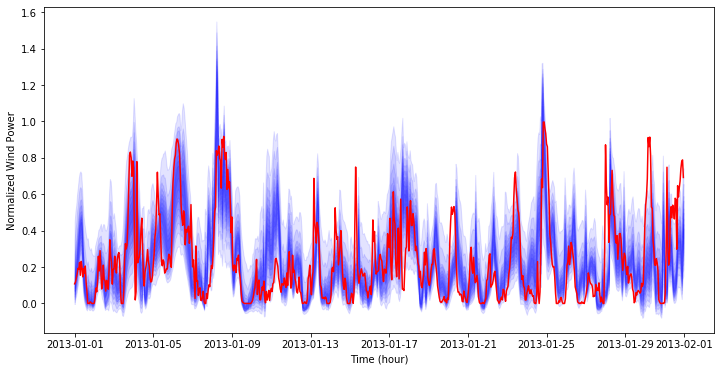

In [9]:
y_test = experiment['y_test']
N_PI = experiment['N_PI']
    
plt.figure(figsize=(12,6))
plt.plot(y_test, color='red')
x = y_test.index.values
for i in range(N_PI):
    y1 = q_hat.iloc[:,i]
    y2 = q_hat.iloc[:,-1-i]
    plt.fill_between(x, y1, y2, color='blue', alpha=str(1/N_PI))
plt.ylabel('Normalized Wind Power')
plt.xlabel('Time (hour)');